In [1]:
# multi-class classification with Keras
import pandas as pd
import numpy as np
import collections
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
import os

In [2]:
def data_scaler(csv):
    
    angle_columns = ['aoaAzResult_1','aoaAzResult_2','aoaAzResult_3',
            'aoaAzResult_4','aoaAzResult_5','aodAzResult_1',
            'aodAzResult_2','aodAzResult_3','aodAzResult_4',
                     'aodAzResult_5']
    snr_columns = ['snrResult_1','snrResult_2',
           'snrResult_3','snrResult_4','snrResult_5']
    csv[angle_columns] = csv[angle_columns]/180.0
    snr_max = np.max(csv['snrResult_1'])
    csv[snr_columns] = csv[snr_columns]/snr_max
    
    return csv

In [3]:
# load dataset
# train on 18 maps
train_map_names = ['Colebrook',\
 'Dryville','Dunmor','Goffs','Hainesburg','Hambleton',\
 'Hominy','Kerrtown','Maryhill','Mesic','Micanopy','Nicut',\
 'Nimmons','Nuevo','Pettigrew','Placida','Quantico','Rancocas']
data_path = []

for mapi in train_map_names:
    data_path.append('.\\Data\\'+mapi+'\\'+mapi+'_Tx_')

n_tx = 10
_columns = ['aoaAzResult_1','aoaAzResult_2','aoaAzResult_3',
            'aoaAzResult_4','aoaAzResult_5','aodAzResult_1',
            'aodAzResult_2','aodAzResult_3','aodAzResult_4',
            'aodAzResult_5','snrResult_1','snrResult_2',
           'snrResult_3','snrResult_4','snrResult_5']
# Training data
# train in following TX 
train_list = [1,2,3,4,5,6,7,8,9,10]
X_train = np.array([])
for k in range(len(data_path)):
    for i in train_list:
        file_name = data_path[k]+str(i)+'_beam_search.csv'
        csv_data = pd.read_csv(file_name)
        csv_data = data_scaler(csv_data)
        n_rx = csv_data.shape[0]
        if len(X_train) == 0:
            X_train = np.array(csv_data[_columns])
            y_train = np.array(csv_data['linkState'])
        else:
            X_train = np.concatenate((X_train, np.array(csv_data[_columns])))
            y = np.array(csv_data['linkState'])
            y_train = np.concatenate((y_train,y))


In [4]:
X_train.shape

(483690, 15)

In [5]:
X_train[1,:]

array([-0.65555556, -0.6       , -0.87777778, -0.30555556, -0.72222222,
        0.70833333,  0.70833333,  0.70833333,  0.66666667,  0.75      ,
        0.89427631,  0.48047407,  0.41418833,  0.25984806,  0.21845871])

In [6]:
np.unique(y_train)

array([0, 1, 2, 3], dtype=int64)

In [7]:
y_train

array([2, 2, 2, ..., 0, 0, 0], dtype=int64)

In [8]:
# Test data
# test on 20 maps
test_map_names=['Adrian','Bowlus','Reyno','Roeville','Sanctuary','Sawpit','Seward','Shelbiana',\
 'Silas','Sodaville','Soldier','Spencerville','Spotswood',\
  'Springhill','Stilwell','Sumas','Superior','Woonsocket',\
               'Brevort','Capistrano']
test_path = []
for mapi in test_map_names:
    test_path.append('.\\Data\\'+mapi+'\\'+mapi+'_Tx_')

test_list = [1,2,3,4,5,6,7,8,9,10]
X_test = np.array([])
y_test = np.array([])
nRx_ls = []
for k in range(len(test_path)):
    nRx = 0
    for i in test_list:
        file_name = test_path[k]+str(i)+'_beam_search.csv'
        csv_data = pd.read_csv(file_name)
        csv_data = data_scaler(csv_data)
        n_rx = csv_data.shape[0]
        if k == 0:
            if i == 1:
                nRx = n_rx
                X_test = np.array(csv_data[_columns])
                y_test = np.array(csv_data['linkState'])
            else:
                X_test = np.concatenate((X_test, np.array(csv_data[_columns])))
                y = np.array(csv_data['linkState'])
                y_test = np.concatenate((y_test,y))
        else:
            if i == 1:
                nRx = n_rx
            X_test = np.concatenate((X_test, np.array(csv_data[_columns])))
            y = np.array(csv_data['linkState'])
            y_test = np.concatenate((y_test,y))
    nRx_ls.append(nRx)

In [9]:
X_test.shape

(563810, 15)

In [10]:
np.unique(y_test)
# 0=>Outage; 1=>LOS; 2=>1st NLOS; 3=>2nd+ NLOS

array([0, 1, 2, 3], dtype=int64)

In [11]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_Y = encoder.transform(y_train)
encoded_Y_tr = encoder.transform(y_test)
# convert integers to dummy variables (i.e. one hot encoded)
y_tr = np_utils.to_categorical(encoded_Y)
y_ts = np_utils.to_categorical(encoded_Y_tr)

In [ ]:
# create model
model = Sequential()
model.add(Dense(10, input_dim=15, activation='relu'))
model.add(Dense(6, input_dim=10, activation='relu'))
model.add(Dense(4, activation='softmax'))
# Compile model
opt = optimizers.Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
hist = model.fit(X_train, y_tr, epochs=100, batch_size=1024, validation_data=(X_test,y_ts))

Epoch 1/100
473/473 [==============================] - 3s 4ms/step - loss: 1.2508 - accuracy: 0.3407 - val_loss: 0.6409 - val_accuracy: 0.7555
Epoch 2/100
473/473 [==============================] - 1s 3ms/step - loss: 0.5999 - accuracy: 0.7504 - val_loss: 0.4504 - val_accuracy: 0.8088
Epoch 3/100
473/473 [==============================] - 2s 3ms/step - loss: 0.4550 - accuracy: 0.8066 - val_loss: 0.3757 - val_accuracy: 0.8453
Epoch 4/100
473/473 [==============================] - 1s 3ms/step - loss: 0.4017 - accuracy: 0.8291 - val_loss: 0.3630 - val_accuracy: 0.8476
Epoch 5/100
473/473 [==============================] - 1s 3ms/step - loss: 0.3897 - accuracy: 0.8330 - val_loss: 0.3573 - val_accuracy: 0.8488
Epoch 6/100
473/473 [==============================] - 1s 3ms/step - loss: 0.3850 - accuracy: 0.8342 - val_loss: 0.3519 - val_accuracy: 0.8513
Epoch 7/100
473/473 [==============================] - 1s 3ms/step - loss: 0.3804 - accuracy: 0.8361 - val_loss: 0.3516 - val_accuracy: 0.8506

Epoch 58/100
473/473 [==============================] - 2s 3ms/step - loss: 0.2917 - accuracy: 0.8783 - val_loss: 0.2619 - val_accuracy: 0.8958
Epoch 59/100
473/473 [==============================] - 1s 3ms/step - loss: 0.2904 - accuracy: 0.8796 - val_loss: 0.2631 - val_accuracy: 0.8962
Epoch 60/100
473/473 [==============================] - 1s 3ms/step - loss: 0.2908 - accuracy: 0.8791 - val_loss: 0.2606 - val_accuracy: 0.8962
Epoch 61/100
473/473 [==============================] - 1s 3ms/step - loss: 0.2911 - accuracy: 0.8789 - val_loss: 0.2604 - val_accuracy: 0.8958
Epoch 62/100
473/473 [==============================] - 1s 3ms/step - loss: 0.2921 - accuracy: 0.8785 - val_loss: 0.2602 - val_accuracy: 0.8951
Epoch 63/100
473/473 [==============================] - 1s 3ms/step - loss: 0.2915 - accuracy: 0.8795 - val_loss: 0.2603 - val_accuracy: 0.8959
Epoch 64/100
473/473 [==============================] - 1s 3ms/step - loss: 0.2908 - accuracy: 0.8793 - val_loss: 0.2639 - val_accuracy:

In [19]:
model.save_weights("aoa_aod_model",save_format='h5')

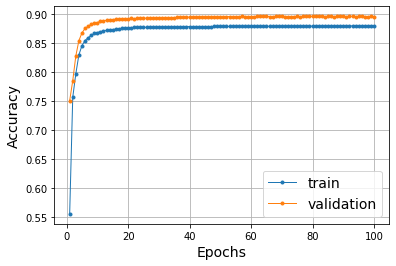

In [22]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
train_acc= hist.history['accuracy']
val_acc = hist.history['val_accuracy']
nepochs = len(val_acc)
plt.plot(np.arange(1,nepochs+1), train_acc, '.-', linewidth=1)
plt.plot(np.arange(1,nepochs+1), val_acc, '.-', linewidth=1)
plt.grid()
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(['train','validation'],loc='lower right',fontsize=14)
plt.savefig('acc.png', dpi=500)

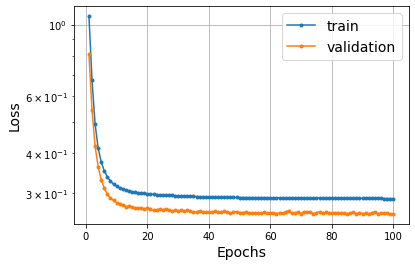

In [30]:
fig = plt.figure()
loss = hist.history['loss']
val_loss = hist.history['val_loss']
plt.semilogy(np.arange(1,nepochs+1), loss, '.-')
plt.semilogy(np.arange(1,nepochs+1), val_loss, '.-')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.grid()
plt.legend(['train','validation'],loc='upper right', fontsize=14)
plt.savefig('loss.png', bbox_inches='tight',dpi=500)

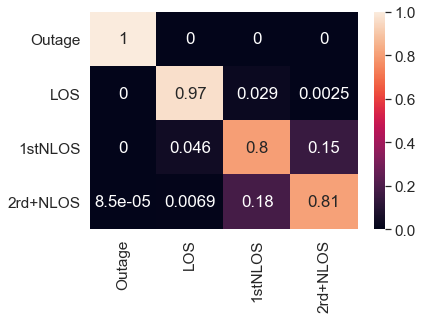

In [21]:
from sklearn.metrics import confusion_matrix
_prob = model.predict(X_test)
y_pre = np.argmax(_prob, axis=-1)
_cf_matrix = confusion_matrix(y_test, y_pre, normalize='true')
import seaborn as sn
df_cm = pd.DataFrame(_cf_matrix, range(4), range(4))
axis_labels = ['Outage','LOS','1stNLOS','2rd+NLOS'] # labels for x-axis and y-axis
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, xticklabels=axis_labels, yticklabels=axis_labels ) # font size
plt.show()